## **Rede Neural - Regressão** <br> COC361 - Inteligência Computacional (2021.2)
### Alunos: <br> Henrique Chaves (DRE 119025571) <br> Pedro Boechat (DRE 119065050)
<hr>

### • Importação das bibliotecas

In [235]:
# Bibliotecas padrão
import pickle

# Bibliotecas do Jupyter
from IPython.display import display

# Bibliotecas para manipulação dos dados
import numpy as np
import pandas as pd

# SKLearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
    mean_absolute_error as mae
)

# Tensorflow/Keras
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.models import Sequential

from scikeras.wrappers import KerasRegressor
from tensorflow.config import list_physical_devices
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Bibliotecas para plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# Número de GPUs disponíveis para o Tensorflow/Keras
print("Número de GPUs disponíveis: ", len(list_physical_devices('GPU')))

Número de GPUs disponíveis:  1


### • Download do dataset ([Link](https://www.kaggle.com/contactprad/bike-share-daily-data?select=bike_sharing_daily.csv))

### • Carregamento do dataset

In [153]:
# Carregamento dos dados
df = pd.read_csv("./data/regression/bike_sharing_daily.csv")

### • Estudo do dataset
```
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered
```

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [155]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [156]:
display(df.head())
display(df.tail())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


### • Análise Exploratória dos Dados

#### 1. Heatmap de correlação

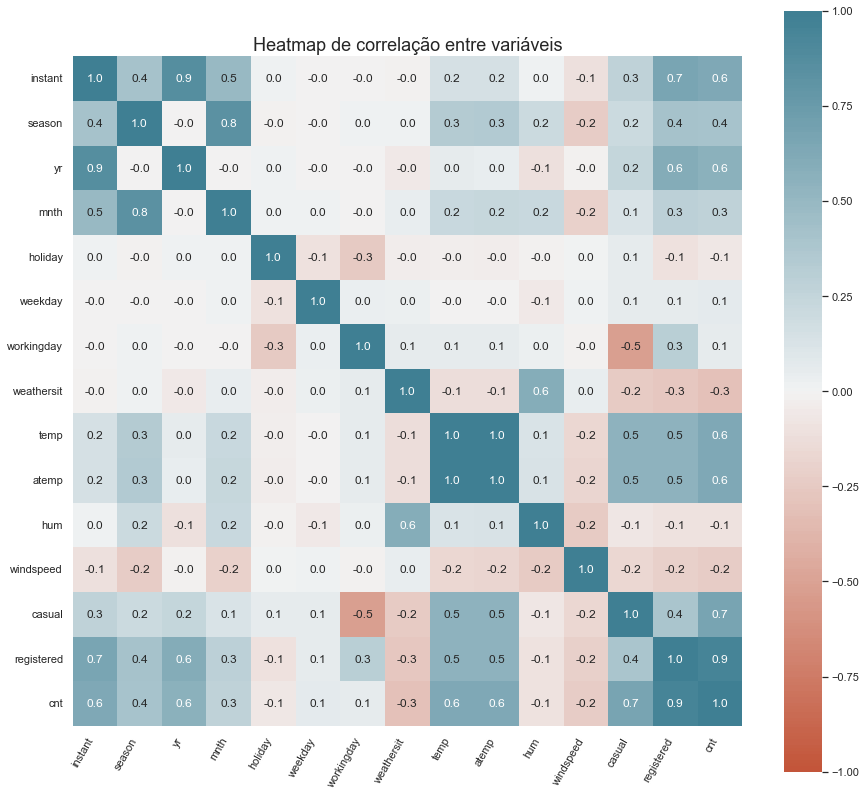

In [166]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=200), square=True, 
            annot=True, fmt=".1f", 
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment="right")
ax.set_title("Heatmap de correlação entre variáveis", fontsize=18)
plt.show()

#### 2. Boxplots

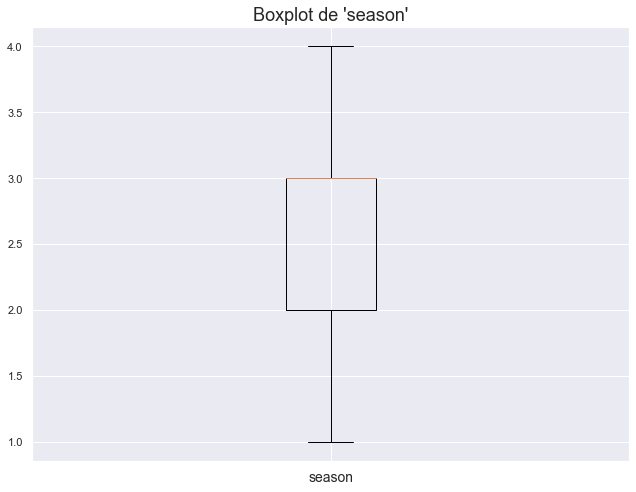

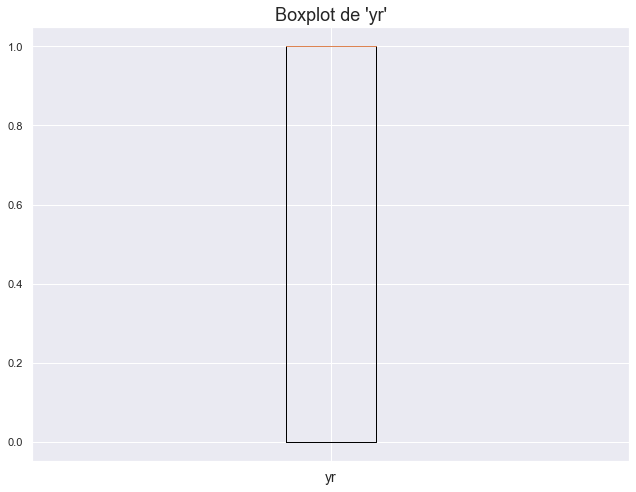

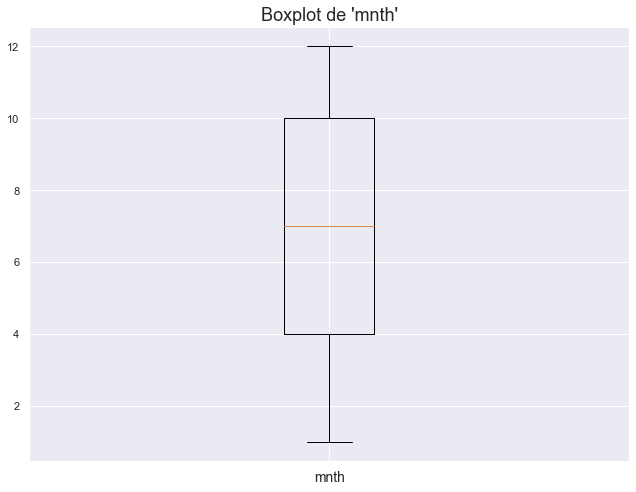

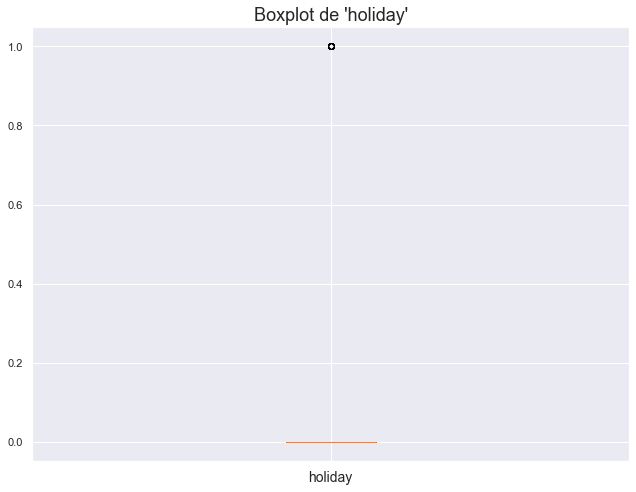

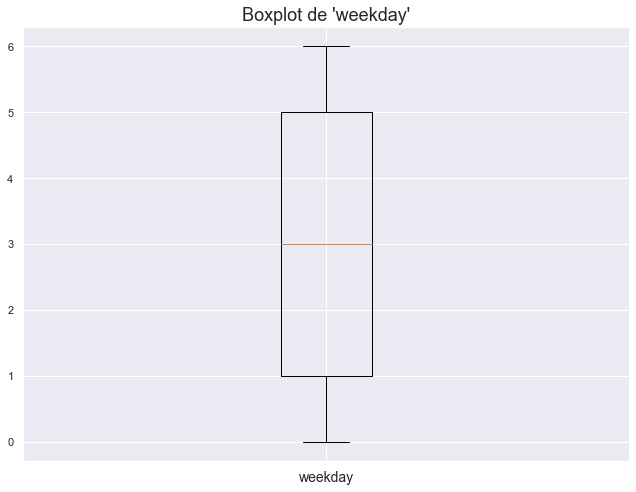

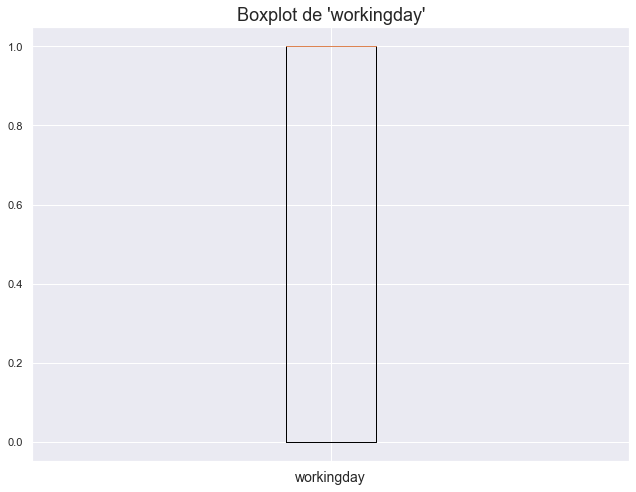

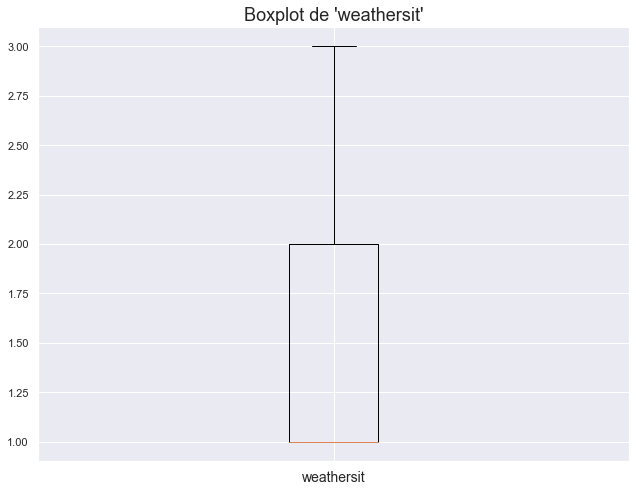

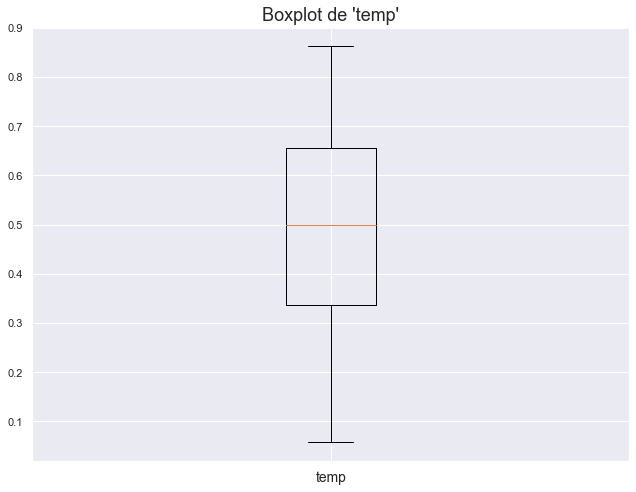

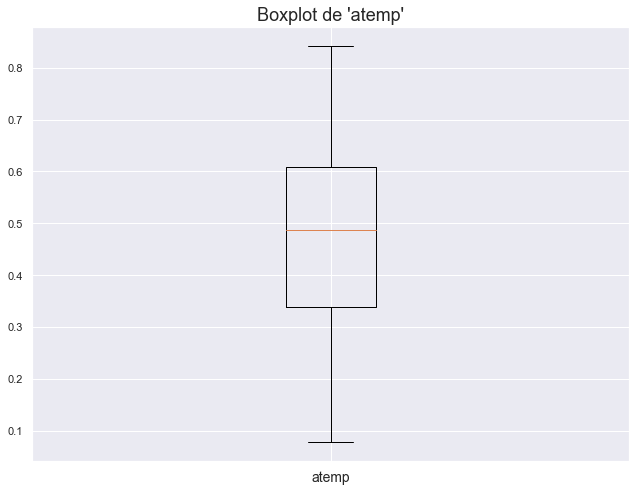

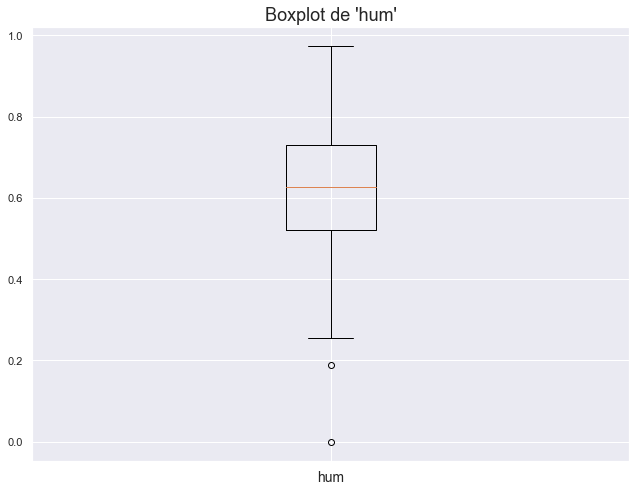

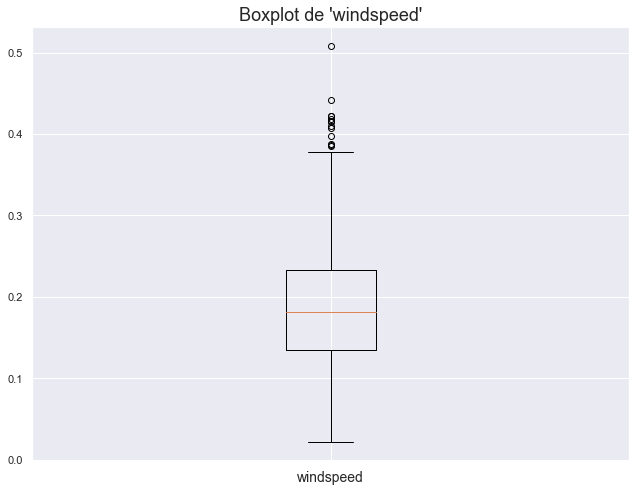

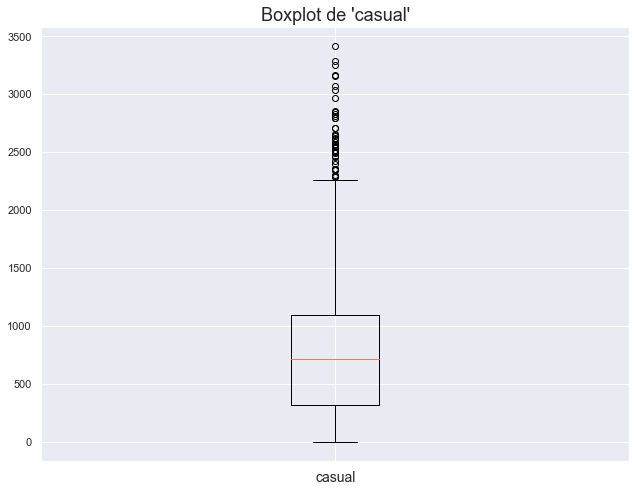

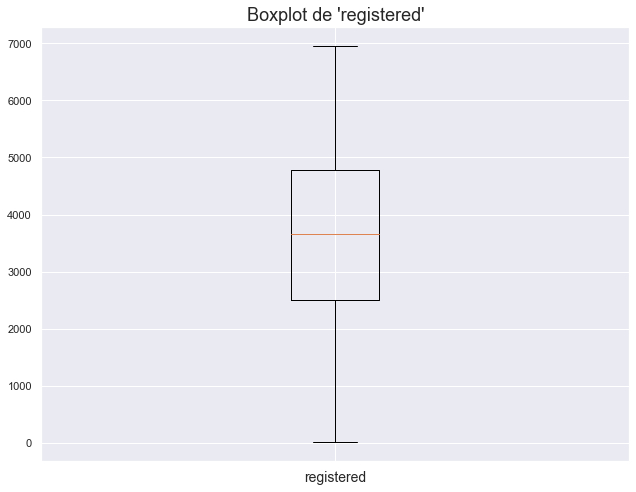

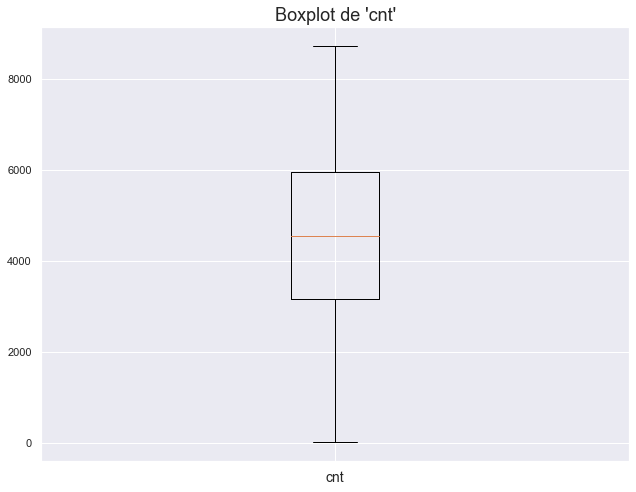

In [178]:
for c in [c for c in df.columns if c not in ["instant","dteday"]]:
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.boxplot(df[c])
    ax.set_title(f"Boxplot de '{c}'", fontsize=18)
    ax.set_xticklabels([c], fontsize=14)
    fig.tight_layout()
    plt.show()

#### 3. Histogramas

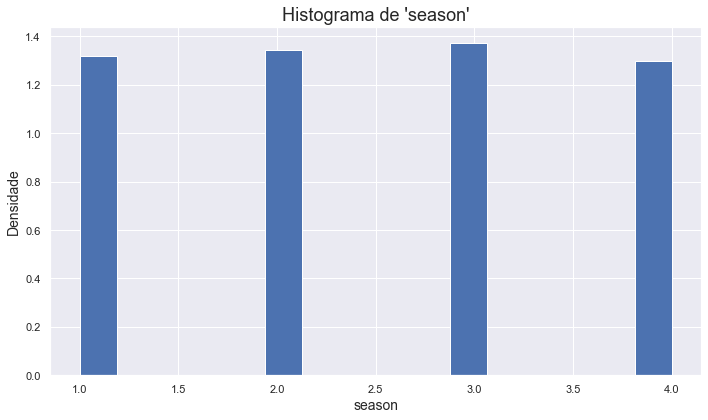

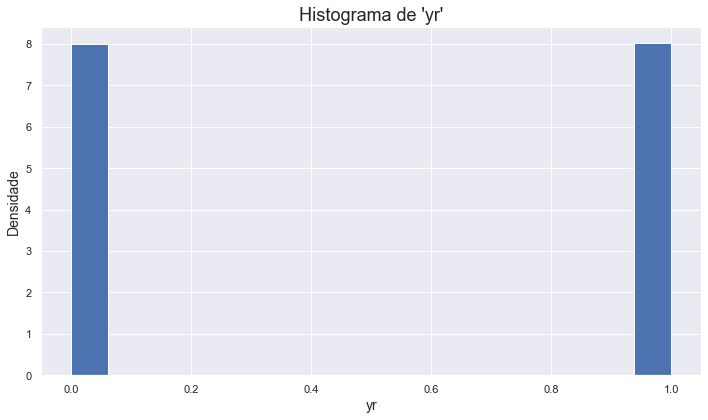

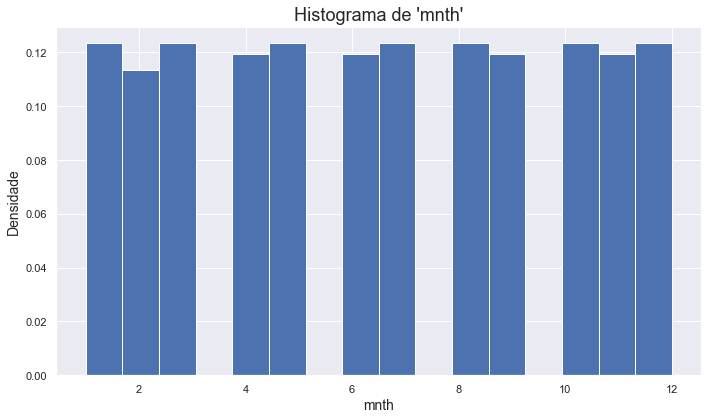

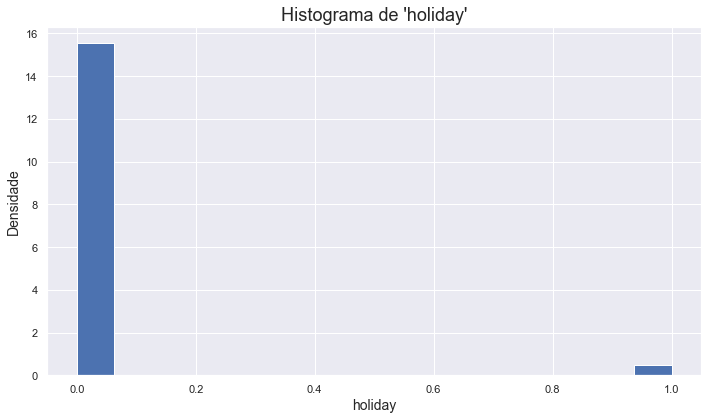

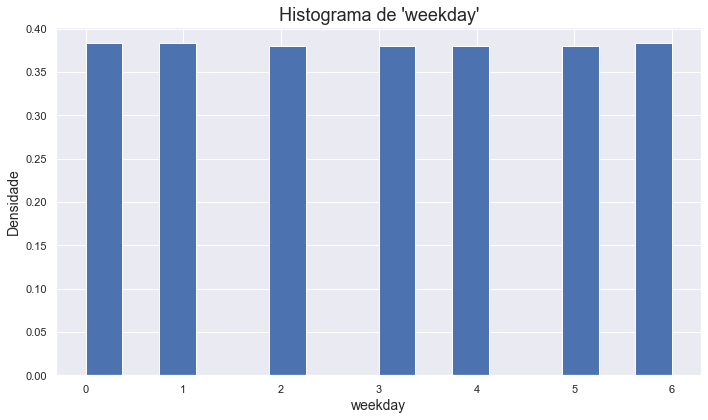

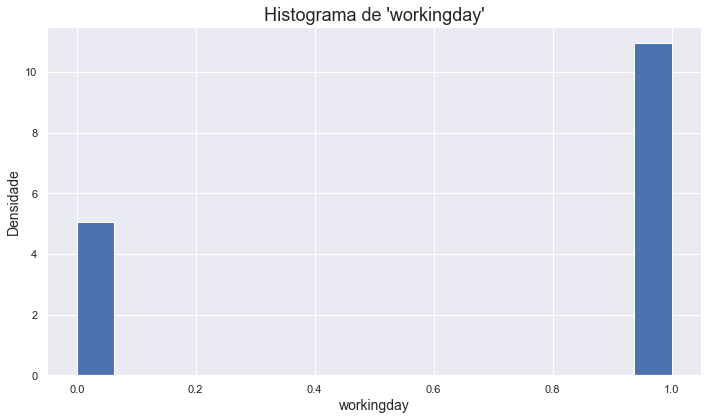

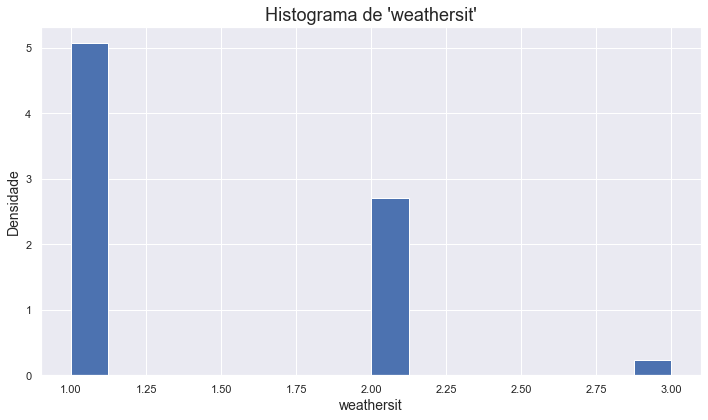

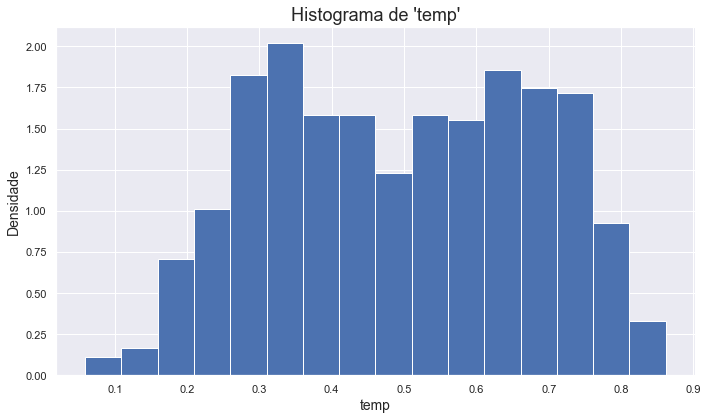

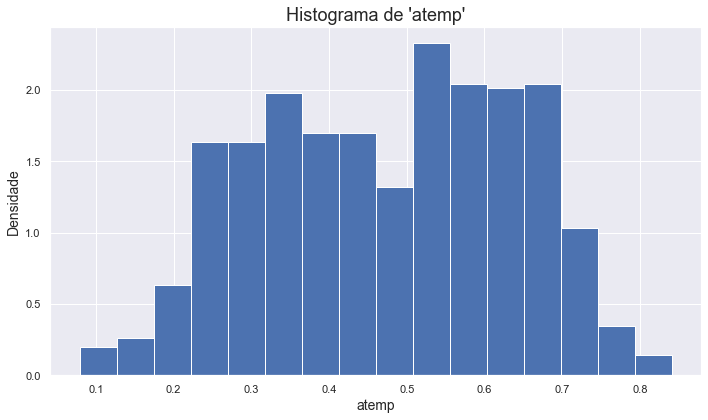

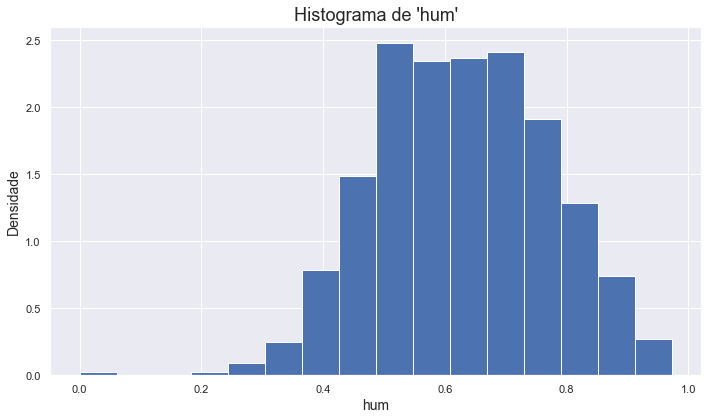

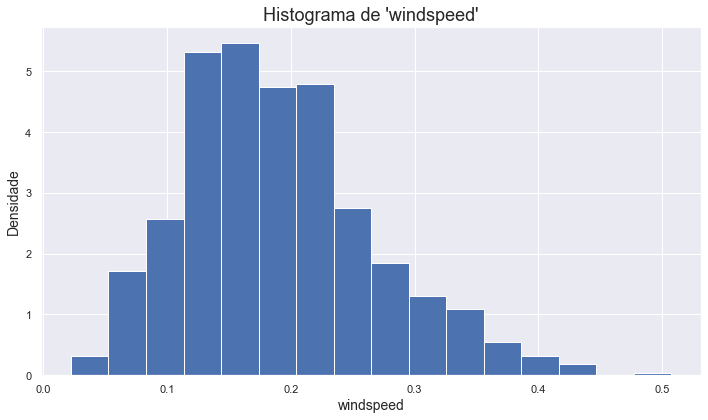

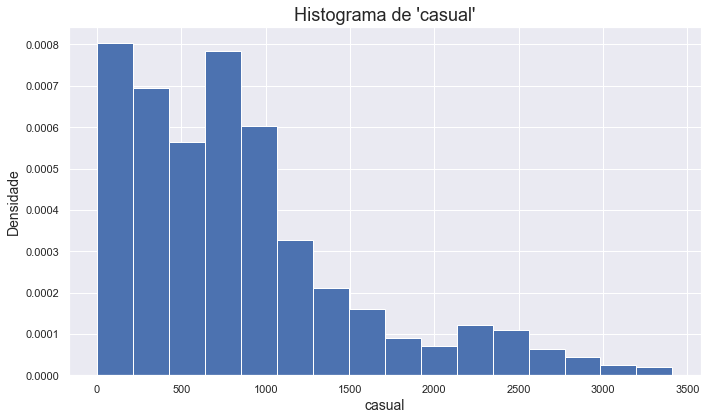

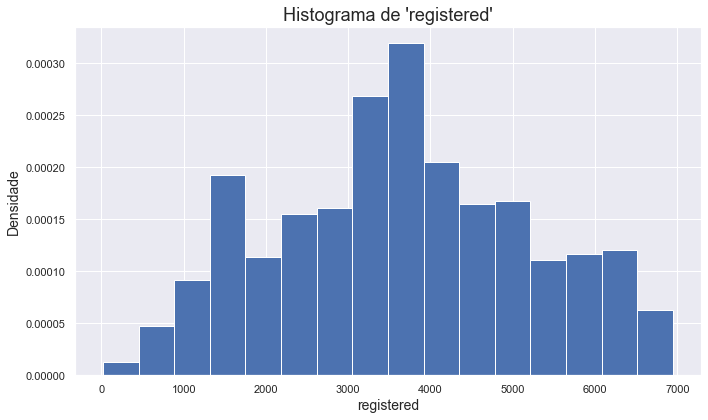

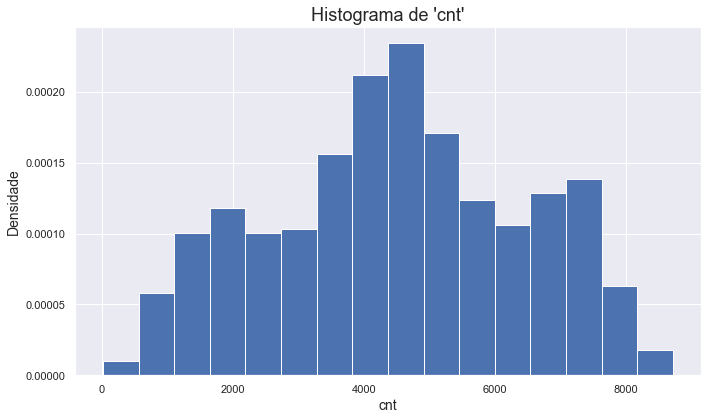

In [251]:
for c in [c for c in df.columns if c not in ["instant","dteday"]]:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(df[c], density=True, bins=16)
    ax.set_title(f"Histograma de '{c}'", fontsize=18)
    ax.set_xlabel(c, fontsize=14)
    ax.set_ylabel("Densidade", fontsize=14)
    fig.tight_layout()
    plt.show()

#### 4. Séries temporais

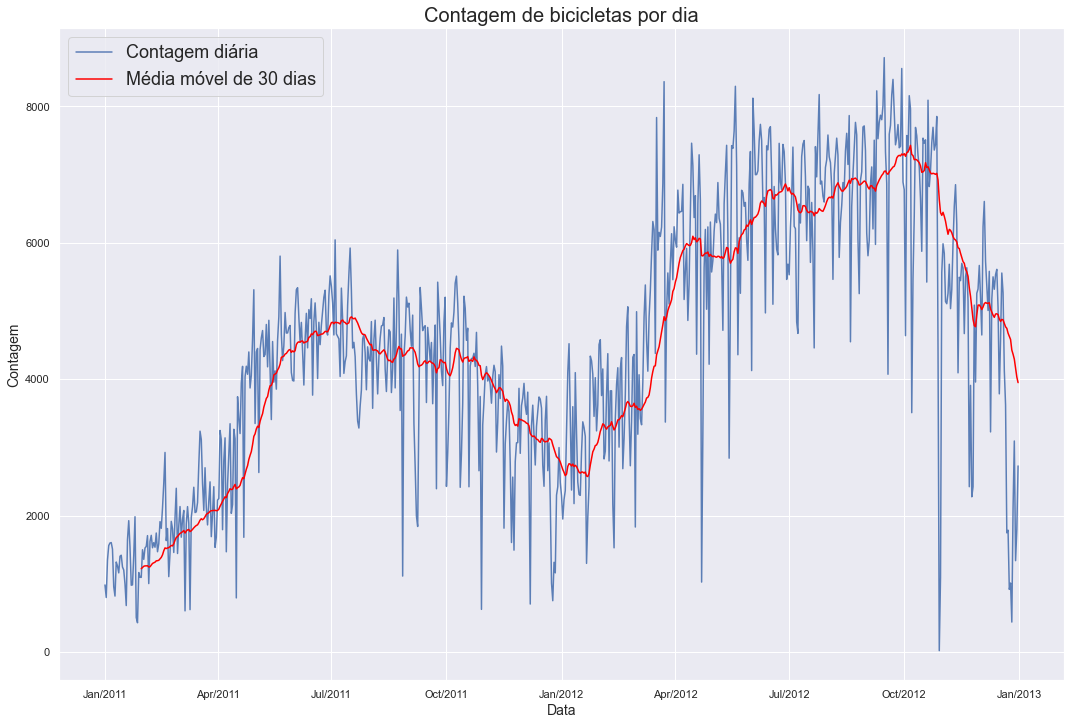

In [229]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(pd.to_datetime(df["dteday"]), df["cnt"], label="Contagem diária", alpha=0.9)
ax.plot(pd.to_datetime(df["dteday"]), df["cnt"].rolling(30).mean(), color="red", label="Média móvel de 30 dias")
ax.set_title("Contagem de bicicletas por dia", fontsize=20)
ax.set_xlabel("Data", fontsize=14)
ax.set_ylabel("Contagem", fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.legend(fontsize=18);

### • Limpeza dos dados

#### 1. Remover coluna `instant`

In [ ]:
# Remove coluna `instant` se for igual ao índice do dataset
if np.all(df.index == df["instant"] - 1):
    df = df.drop("instant", axis=1)

print("df shape:", df.shape)
df.sample(5)

df shape: (731, 15)


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
607,2012-08-30,3,1,8,0,4,1,1,0.706667,0.652779,0.590417,0.077117,1172,6541,7713
177,2011-06-27,3,0,6,0,1,1,2,0.682500,0.637004,0.658333,0.107588,854,3854,4708
584,2012-08-07,3,1,8,0,2,1,2,0.735833,0.697621,0.703750,0.116908,1278,5995,7273
444,2012-03-20,1,1,3,0,2,1,1,0.560833,0.538533,0.807917,0.121271,1051,5042,6093
24,2011-01-25,1,0,1,0,2,1,2,0.223478,0.234526,0.616957,0.129796,186,1799,1985


#### 2. Converter coluna `season` para variáveis dummies

In [ ]:
dummies_season = pd.get_dummies(df["season"], drop_first=True)
dummies_season = dummies_season.rename(
    columns={
        2: "is_summer",
        3: "is_fall",
        4: "is_winter"
    }
)

print("dummies_season shape:", dummies_season.shape)
dummies_season.sample(5)

dummies_season shape: (731, 3)


,is_summer,is_fall,is_winter
396,0,0,0
395,0,0,0
509,1,0,0
271,0,0,1
339,0,0,1


In [ ]:
df = df.drop("season", axis=1)
df = pd.concat([df, dummies_season], axis=1)
print("df shape:", df.shape)
df.sample(5)

df shape: (731, 17)


,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,is_summer,is_fall,is_winter
195,2011-07-15,0,7,0,5,1,1,0.663333,0.624371,0.591250,0.182833,1318,4220,5538,0,1,0
374,2012-01-10,1,1,0,2,1,1,0.308696,0.318826,0.646522,0.187552,173,3425,3598,0,0,0
483,2012-04-28,1,4,0,6,0,2,0.376667,0.377504,0.489583,0.129975,1120,3100,4220,1,0,0
199,2011-07-19,0,7,0,2,1,1,0.776667,0.747479,0.650417,0.130600,752,3789,4541,0,1,0
420,2012-02-25,1,2,0,6,0,1,0.290833,0.255675,0.395833,0.421642,317,2415,2732,0,0,0


#### 3. Converter colunas `mnth` e `weekday` para variáveis cíclicas usando `sin` e `cos`

In [ ]:
df["mnth_cos"] = np.cos(df["mnth"]*np.pi/6)
df["mnth_sin"] = np.cos(df["mnth"]*np.pi/6)
df["weekday_cos"] = np.cos((df["weekday"]+1)*2*np.pi/7)
df["weekday_sin"] = np.cos((df["weekday"]+1)*2*np.pi/7)

df = df.drop(["mnth", "weekday"], axis=1)
print("df shape:", df.shape)
df.sample(5)

df shape: (731, 19)


,dteday,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,is_summer,is_fall,is_winter,mnth_cos,mnth_sin,weekday_cos,weekday_sin
482,2012-04-27,1,0,1,1,0.457500,0.452637,0.400833,0.347633,1014,5219,6233,1,0,0,-0.5,-0.5,0.623490,0.623490
399,2012-02-04,1,0,0,2,0.264167,0.272725,0.779583,0.121896,384,2448,2832,0,0,0,0.5,0.5,1.000000,1.000000
338,2011-12-05,0,0,1,2,0.385833,0.393925,0.827083,0.062208,233,3578,3811,0,0,1,1.0,1.0,-0.222521,-0.222521
414,2012-02-19,1,0,0,2,0.280000,0.265788,0.515833,0.253112,618,2071,2689,0,0,0,0.5,0.5,0.623490,0.623490
644,2012-10-06,1,0,0,1,0.554167,0.538521,0.664167,0.268025,3031,4934,7965,0,0,1,0.5,0.5,1.000000,1.000000


#### 4. Desnormalizar colunas `temp`, `atemp`, `hum` e `windspeed`

In [ ]:
df["temp"] *= 41
df["atemp"] *= 50
df["hum"] *= 100
df["windspeed"] *= 67

print("df shape:", df.shape)
df.sample(5)

df shape: (731, 19)


,dteday,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,is_summer,is_fall,is_winter,mnth_cos,mnth_sin,weekday_cos,weekday_sin
447,2012-03-23,1,0,1,2,24.668347,28.50335,69.4167,7.792100,2469,5893,8362,1,0,0,6.123234e-17,6.123234e-17,0.623490,0.623490
691,2012-11-22,1,1,0,1,13.940000,17.51855,58.0417,3.542344,955,1470,2425,0,0,1,8.660254e-01,8.660254e-01,-0.222521,-0.222521
3,2011-01-04,0,0,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0,0,0,8.660254e-01,8.660254e-01,-0.900969,-0.900969
540,2012-06-24,1,0,0,1,30.476653,33.71270,47.9167,9.750175,2551,4340,6891,0,1,0,-1.000000e+00,-1.000000e+00,0.623490,0.623490
493,2012-05-08,1,0,1,2,23.848347,27.87355,68.5833,19.833943,738,4990,5728,1,0,0,-8.660254e-01,-8.660254e-01,-0.900969,-0.900969


#### 5. Remover colunas `casual` e `registered` pois a soma delas é igual a `cnt` (variável alvo)

In [ ]:
if np.all(df["casual"] + df["registered"] == df["cnt"]):
    df = df.drop(["casual", "registered"], axis=1)

print("df shape:", df.shape)
df.sample(5)

df shape: (731, 17)


,dteday,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,is_summer,is_fall,is_winter,mnth_cos,mnth_sin,weekday_cos,weekday_sin
420,2012-02-25,1,0,0,1,11.924153,12.78375,39.5833,28.250014,2732,0,0,0,5.000000e-01,5.000000e-01,1.000000,1.000000
293,2011-10-21,0,0,1,1,17.527500,21.17980,57.4167,14.833532,4304,0,0,1,5.000000e-01,5.000000e-01,0.623490,0.623490
726,2012-12-27,1,0,1,2,10.420847,11.33210,65.2917,23.458911,2114,0,0,0,1.000000e+00,1.000000e+00,-0.222521,-0.222521
160,2011-06-10,0,0,1,1,30.955000,35.16460,60.5000,9.417118,4586,1,0,0,-1.000000e+00,-1.000000e+00,0.623490,0.623490
75,2011-03-17,0,0,1,1,17.015000,20.51665,60.2917,14.041793,2744,0,0,0,6.123234e-17,6.123234e-17,-0.222521,-0.222521


### • Salvar dataset limpo

In [ ]:
df.to_csv("./data/regression/df_clean.csv", index=False)

### • Definindo `features` e  `targets`

In [ ]:
features = ["yr", "holiday", "workingday", "weathersit",
            "temp", "atemp", "hum", "windspeed",
            "is_summer", "is_fall", "is_winter",
            "mnth_cos", "mnth_sin", "weekday_cos", "weekday_sin"]

targets = ["cnt"]

In [ ]:
df_X = df[features]

print("df_X shape:", df_X.shape)
df_X.sample(5)

df_X shape: (731, 15)


,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,is_summer,is_fall,is_winter,mnth_cos,mnth_sin,weekday_cos,weekday_sin
134,0,0,0,2,23.062500,26.80000,86.7083,10.249593,1,0,0,-0.866025,-0.866025,0.623490,0.623490
420,1,0,0,1,11.924153,12.78375,39.5833,28.250014,0,0,0,0.500000,0.500000,1.000000,1.000000
348,0,0,1,2,17.322500,20.61185,63.4167,17.958814,0,0,1,1.000000,1.000000,-0.222521,-0.222521
376,1,0,1,2,15.682500,19.09690,80.2917,12.124789,0,0,0,0.866025,0.866025,-0.222521,-0.222521
471,1,1,0,1,27.230847,30.74625,56.1667,19.083543,1,0,0,-0.500000,-0.500000,-0.222521,-0.222521


In [ ]:
df_y = df[targets]

print("df_y shape:", df_y.shape)
df_y.sample(5)

df_y shape: (731, 1)


,cnt
576,7105
325,1607
354,2660
242,5058
193,4342


### • Normalização dos dados

In [ ]:
# Definição do scaler
scaler = MinMaxScaler

# Instância do scaler para X e Y
X_scaler = scaler()
y_scaler = scaler()

In [ ]:
X = X_scaler.fit_transform(df_X)
y = y_scaler.fit_transform(df_y)


print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (731, 15)
y shape: (731, 1)


### • Definição de callbacks da rede

In [ ]:
def create_model(
    n_hidden_layers,
    n_neurons,
    dropout_rate,
    dropout_last_layer,
    learning_rate=0.001,
    input_shape=(X.shape[1], )
):
    """Função que retorna o modelo compilado a partir dos parâmetros.
    Args:
        n_layers (int): Número de camadas da rede. 2 por padrão.
        n_neurons (int): Número de neurônios da rede. 32 por padrão.
        dropout_rate (float): Taxa de dropout. 0.2 por padrão.
        dropout_last_layer (bool): Se terá dropout na última camada.
        False por padrão.
        learning_rate (float): Learning rate do modelo. 0.001 por padrão.
        input_shape (List[int]): Forma da entrada. [99] por padrão.
    """
    # Criação do modelo sequencial
    model = Sequential()

    # Número de variáveis de entrada
    model.add(
            Dense(
                n_neurons,
                activation='relu',
                input_shape=input_shape
            )
        )

    for i in range(n_hidden_layers):
        # Camada de adensamento com ativação RELU
        model.add(
            Dense(
                n_neurons,
                activation='relu'
            )
        )

        # Camada de dropout
        if dropout_rate > 0.0:
            if (i == n_hidden_layers - 1) and (not dropout_last_layer):
                continue
            model.add(
                Dropout(
                    dropout_rate
                )
            )

    # Camada de adensamento com ativação LINEAR
    model.add(Dense(1, activation='linear'))

    # Otimizador Adam
    # optimizer = Adam(learning_rate=learning_rate)

    # Compilação do modelo
    model.compile(
        optimizer="adam",
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
# Reduz a learning rate caso o modelo esteja estagnado
lr_reduce = ReduceLROnPlateau(
    min_delta=1e-5,
    patience=5,
    verbose=1
)

# Lista contendo os checkpoints definidos
callbacks = [
    lr_reduce
]

### • Definição das camadas da rede

In [ ]:
# Criação do regressor com wrapper do SKLearn
regressor = KerasRegressor(
    model=create_model,
    n_hidden_layers=1,
    n_neurons=32,
    dropout_rate=0.0,
    dropout_last_layer=False,
    batch_size=32,
    epochs=100,
)

In [ ]:
# Parâmetros para o Grid Search
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_neurons": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "dropout_last_layer": [False, True]
}

In [ ]:
# Instância do Grid Search
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=1
)

### • Treino da rede

In [ ]:
# Treino do modelo
grid_result = grid_search.fit(
    X, y,
    callbacks=callbacks,
    verbose=0
)

3/3 [==============================] - 0s 2ms/step


In [ ]:
# with open("./data/regression/regression_grid_result.pkl", "wb") as f:
#     pickle.dump(grid_result, f)

In [ ]:
with open("./data/regression/regression_grid_result.pkl", "rb") as f:
    grid_result = pickle.load(f)

In [ ]:
df_grid = pd.DataFrame.from_dict(grid_result.cv_results_)
df_grid = df_grid[[
    "mean_test_score",
    "std_test_score",
    "param_dropout_last_layer",
    "param_dropout_rate",
    "param_n_hidden_layers",
    "param_n_neurons"
]]

In [ ]:
df_grid = df_grid.sort_values(by="mean_test_score", ascending=False).reset_index(drop=True)

In [ ]:
df_grid.head()

,mean_test_score,std_test_score,param_dropout_last_layer,param_dropout_rate,param_n_hidden_layers,param_n_neurons
0,-0.009708,0.004311,True,0.0,1,128
1,-0.009730,0.005869,True,0.2,1,128
2,-0.009774,0.004409,False,0.2,1,128
3,-0.009903,0.003870,True,0.0,3,128
4,-0.009910,0.004573,False,0.0,2,128


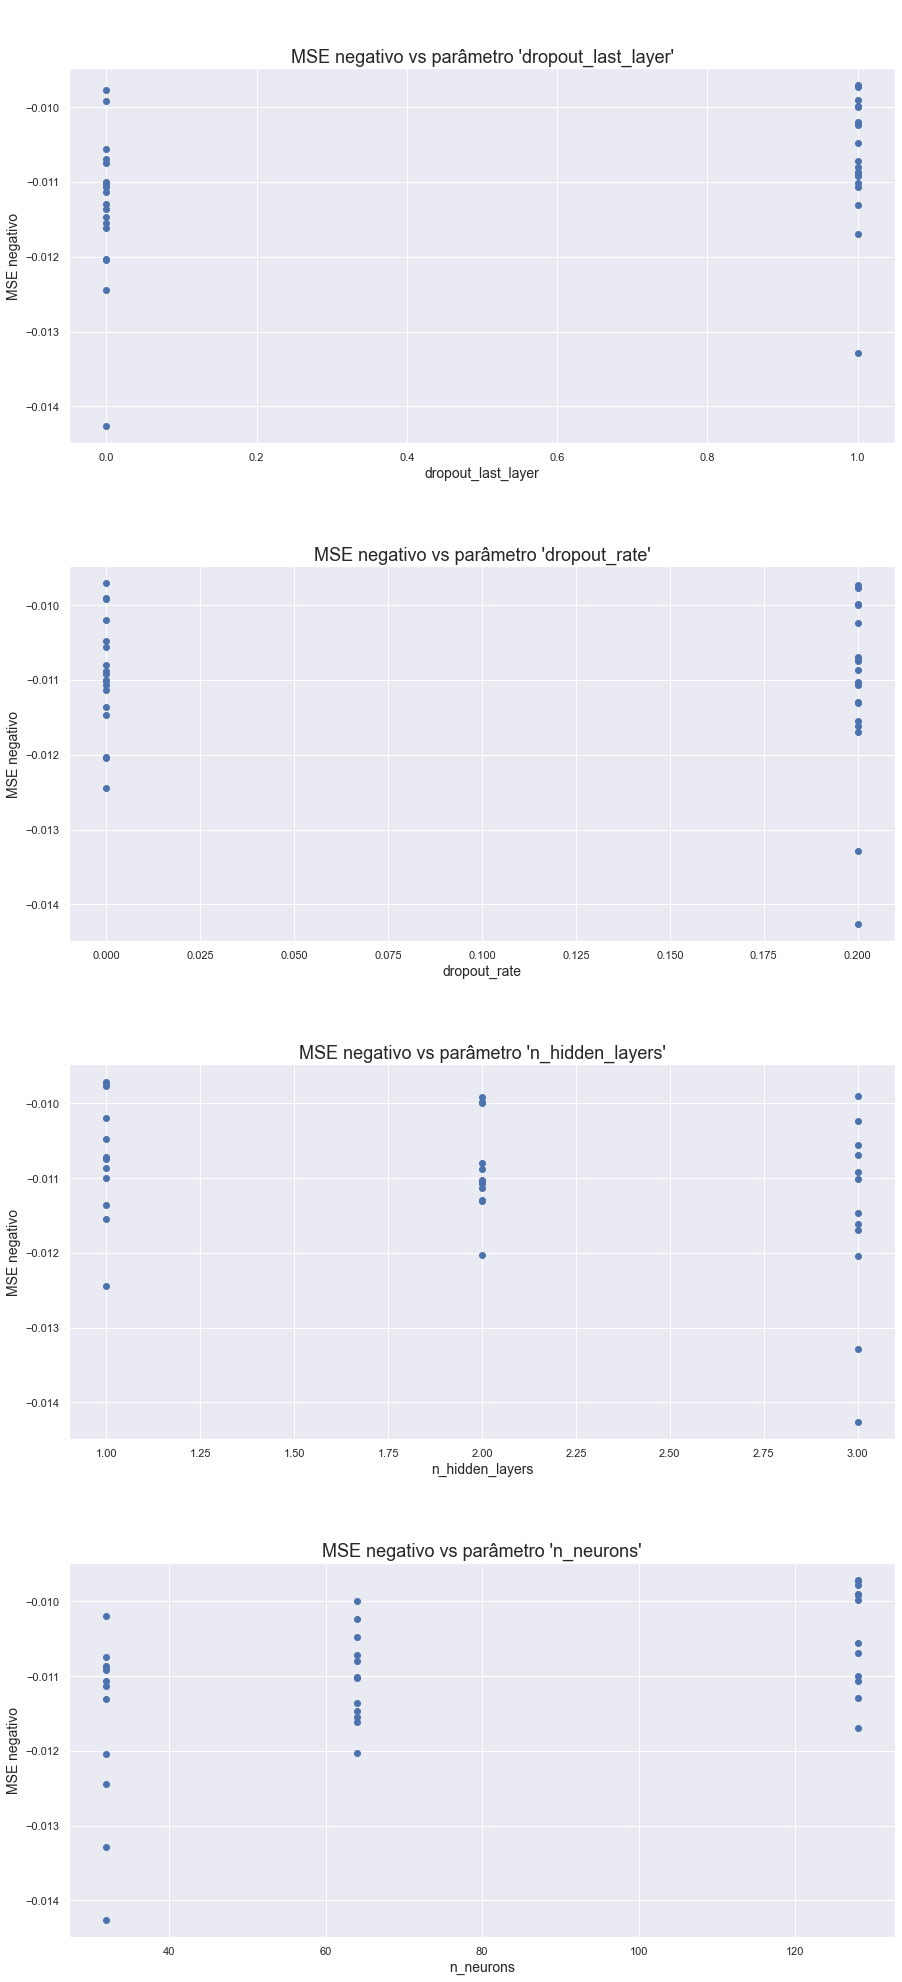

In [233]:
fig, ax = plt.subplots(nrows=4, figsize=(13, 4*7))
params_list = df_grid.columns[2:]

for i in range(4):
    ax[i].scatter(df_grid[params_list[i]], df_grid["mean_test_score"])
    ax[i].set_title(f"\n\nMSE negativo vs parâmetro '{params_list[i][6:]}'", fontsize=18)
    ax[i].set_xlabel(params_list[i][6:], fontsize=14)
    ax[i].set_ylabel("MSE negativo", fontsize=14)

fig.tight_layout(pad=2.0)
plt.show()

### • Avaliação da rede

In [ ]:
history = grid_result.best_estimator_.history_

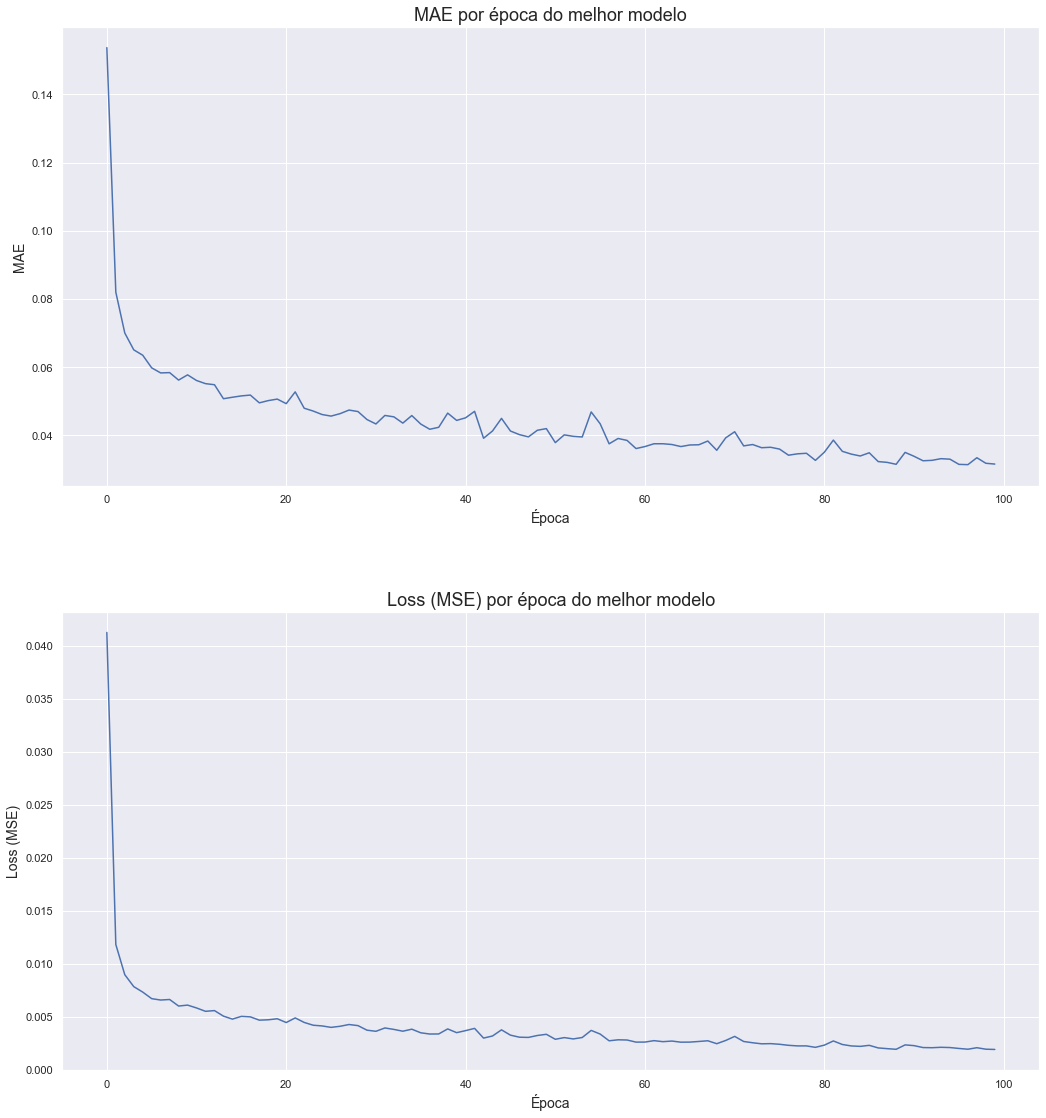

In [230]:
# Definição dos subplots
fig, ax = plt.subplots(figsize=(15, 16), nrows=2)

# Gráfico do MAE do modelo por época
ax[0].plot(history['mean_absolute_error'])
ax[0].set_title('MAE por época do melhor modelo', fontsize=18)
ax[0].set_ylabel('MAE', fontsize=14)
ax[0].set_xlabel('Época', fontsize=14)

# Gráfico da loss do modelo por época
ax[1].plot(history['loss'])
ax[1].set_title('\n\nLoss (MSE) por época do melhor modelo', fontsize=18)
ax[1].set_ylabel('Loss (MSE)', fontsize=14)
ax[1].set_xlabel('Época', fontsize=14)

# Ajuste do layout do plot
fig.tight_layout(pad=2.0)
plt.show()

### • Predição usando a rede treinada

In [ ]:
y_pred = grid_result.best_estimator_.predict(X)

23/23 [==============================] - 0s 2ms/step


In [ ]:
ix = pd.to_datetime(df["dteday"])

y_pred_inv = y_scaler.inverse_transform(y_pred)
y_inv = y_scaler.inverse_transform(y)

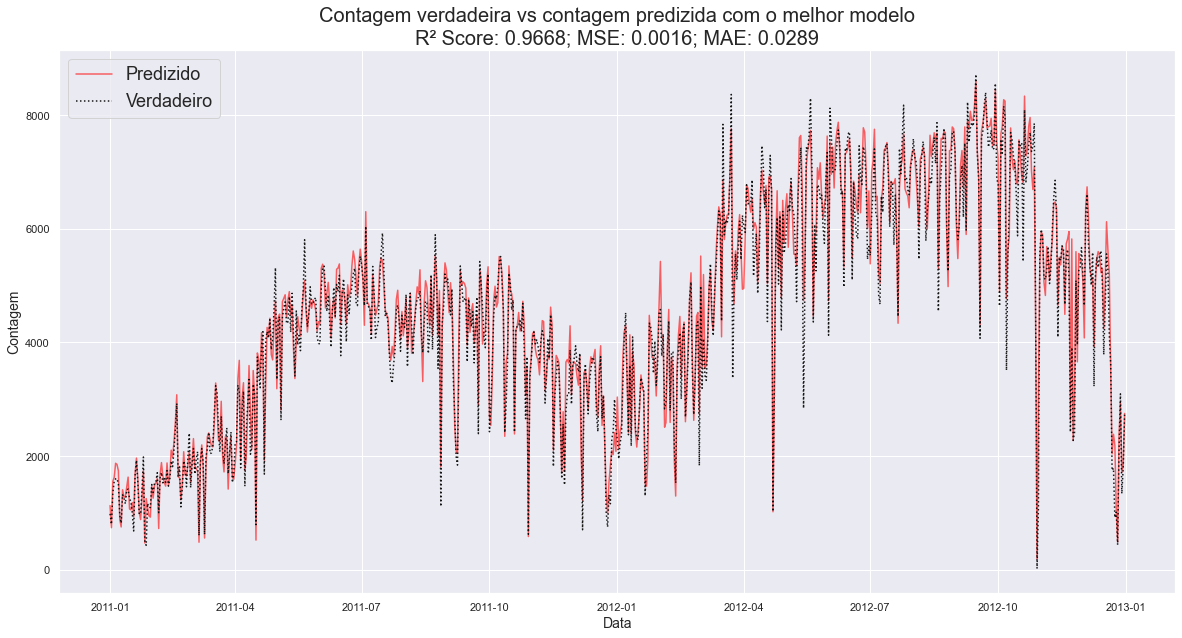

In [250]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(ix, y_pred_inv, label="Predizido", alpha=0.6, color="red")
ax.plot(ix, y_inv, label="Verdadeiro", alpha=0.9, color="black", linestyle="dotted")

ax.set_title(f"Contagem verdadeira vs contagem predizida com o melhor modelo\nR² Score: {r2_score(y, y_pred):.4f}; MSE: {mse(y, y_pred):.4f}; MAE: {mae(y, y_pred):.4f}", fontsize=20)
ax.set_xlabel("Data", fontsize=14)
ax.set_ylabel("Contagem", fontsize=14)
plt.legend(fontsize=18)
plt.show()